In [1]:
!pip install open3d numpy tensorflow matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7

In [2]:
# Google Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import open3d as o3d
import numpy as np
import tensorflow as tf

def load_point_cloud(file_path):
    """
    Load the point cloud from a .ply file.
    """
    point_cloud = o3d.io.read_point_cloud(file_path)
    points = np.asarray(point_cloud.points)  # Extract point coordinates
    return points

def normalize_points(points):
    """
    Normalize the point cloud coordinates to a fixed scale.
    """
    min_vals = np.min(points, axis=0)
    max_vals = np.max(points, axis=0)
    normalized_points = (points - min_vals) / (max_vals - min_vals)
    return normalized_points

# Load and normalize the point cloud
point_cloud_file = "/content/drive/MyDrive/training_point_cloud.ply"
points = load_point_cloud(point_cloud_file)
normalized_points = normalize_points(points)

print(f"Loaded point cloud with {points.shape[0]} points.")

Loaded point cloud with 12400 points.


In [4]:
def preprocess_points(points, num_features=3):
    """
    Prepare points for PointRCNN input by adding dummy intensity values.
    """
    num_points = points.shape[0]
    # Add a dummy intensity channel (e.g., all ones) to match PointRCNN input expectations
    intensity = np.ones((num_points, 1))
    processed_points = np.hstack([points, intensity])  # Shape: (N, 4)
    return processed_points

processed_points = preprocess_points(normalized_points)
print(f"Processed points shape: {processed_points.shape}")

Processed points shape: (12400, 4)


In [5]:
def load_labels(file_path):
    """
    Load labels from a text file, skipping any header lines.
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    labels = np.array([int(line.strip()) for line in lines if not line.startswith("#")])
    return labels

# Load the labels
labels_file_path = "/content/drive/MyDrive/training_labels.txt"
labels = load_labels(labels_file_path)
print(f"Loaded {len(labels)} labels.")

Loaded 12400 labels.


In [6]:
# Assuming the PointRCNN model has already been built or loaded
def build_pointrcnn_model(input_shape, num_classes):
    """
    Build a PointRCNN-like model for classification.
    """
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(32, activation="relu")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)  # Corrected output units
    model = tf.keras.Model(inputs, outputs, name="PointRCNN")
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [7]:
# Define the number of classes
num_classes = len(set(labels))

# Prepare input data for training
input_shape = processed_points.shape[1:]
pointrcnn_model = build_pointrcnn_model(input_shape, num_classes)
pointrcnn_model.summary()


Model: "PointRCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,174 (43.65 KB)

 Trainable params: 11,174 (43.65 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Ensure labels are integers and calculate num_classes
labels = labels.astype(int)
max_label_value = np.max(labels)
num_classes = max_label_value + 1
print(f"Number of classes: {num_classes}")

# Convert labels to one-hot encoding
one_hot_labels = tf.keras.utils.to_categorical(labels[:processed_points.shape[0]], num_classes=num_classes)
print(f"One-hot encoded labels shape: {one_hot_labels.shape}")

Number of classes: 7
One-hot encoded labels shape: (12400, 7)


In [9]:
# Rebuild the model with the correct number of classes
input_shape = processed_points.shape[1:]
pointrcnn_model = build_pointrcnn_model(input_shape, num_classes)
pointrcnn_model.summary()

Model: "PointRCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,207 (43.78 KB)

 Trainable params: 11,207 (43.78 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
history = pointrcnn_model.fit(
    processed_points,
    one_hot_labels,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6937 - loss: 1.0176 - val_accuracy: 0.0323 - val_loss: 9.9267
Epoch 2/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9461 - loss: 0.1283 - val_accuracy: 0.0323 - val_loss: 11.9955
Epoch 3/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9492 - loss: 0.1087 - val_accuracy: 0.0323 - val_loss: 12.8399
Epoch 4/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9529 - loss: 0.1059 - val_accuracy: 0.0323 - val_loss: 13.3863
Epoch 5/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9479 - loss: 0.1069 - val_accuracy: 0.0323 - val_loss: 13.8780
Epoch 6/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9496 - loss: 0.1038 - val_accuracy: 0.0323 - val_loss: 14.4202
Epoch 7/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9505 - loss: 0.1069 - val_accuracy: 0.0323 - val_loss: 14.1068
Epoch 8/100
310/310 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9486 - loss: 0.1032 - va

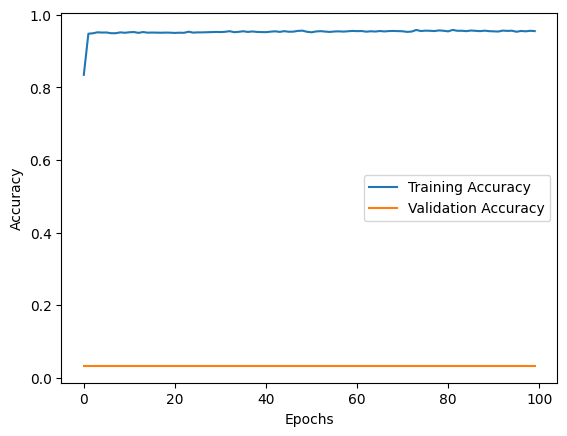

In [11]:
# Plot training accuracy
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [16]:
# Summarize detected objects
def summarize_detected_objects(points, predictions):
    """
    Summarize detected objects and their counts.
    """
    predicted_classes = np.argmax(predictions, axis=1)
    object_points = points[predicted_classes == 1]  # Example: assume class 1 is "object"
    non_object_points = points[predicted_classes == 0]  # Class 0 as non-object

    # Print summary
    print(f"Total Points: {points.shape[0]}")
    print(f"Points identified as objects: {object_points.shape[0]}")
    print(f"Points identified as non-objects: {non_object_points.shape[0]}")

    # If further labels exist, categorize detected objects (example)
    object_classes = {1: "Tree", 2: "Building", 3: "Car", 4: "Person"}  # Example mapping
    unique, counts = np.unique(predicted_classes, return_counts=True)
    print("\nDetected Object Summary:")
    for cls, count in zip(unique, counts):
        obj_name = object_classes.get(cls, f"Unknown (Class {cls})")
        print(f"  - {obj_name}: {count} points")

predictions = pointrcnn_model.predict(processed_points)

# Call the summarization function
summarize_detected_objects(normalized_points[:processed_points.shape[0]], predictions)

388/388 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Total Points: 12400
Points identified as objects: 832
Points identified as non-objects: 0

Detected Object Summary:
  - Tree: 832 points
  - Building: 2303 points
  - Car: 5000 points
  - Person: 4265 points


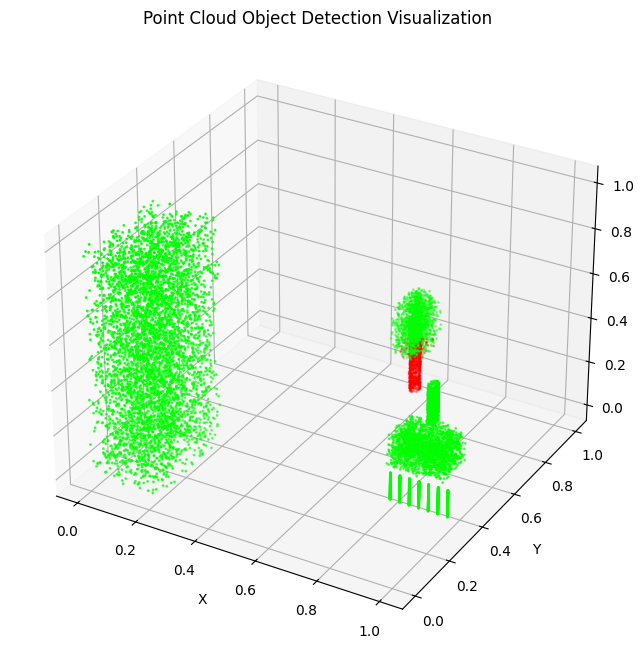

In [18]:
# Visualize results with Matplotlib
def visualize_detected_objects_matplotlib(points, predictions):
    """
    Visualize the point cloud with detected labels using Matplotlib.
    """
    predicted_classes = np.argmax(predictions, axis=1)
    colors = np.array([[1, 0, 0] if cls == 1 else [0, 1, 0] for cls in predicted_classes])  # Red for class 1, Green for class 0

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors, s=1)

    ax.set_title("Point Cloud Object Detection Visualization")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

# Visualize predictions using Matplotlib
visualize_detected_objects_matplotlib(normalized_points[:processed_points.shape[0]], predictions)

In [19]:
# Save PointRCNN model
save_path = "/content/drive/MyDrive/PointRCNN_Detection.h5"
pointrcnn_model.save(save_path)
print(f"PointRCNN model saved to {save_path}")

PointRCNN model saved to /content/drive/MyDrive/PointRCNN_Detection.h5
